## 1. Import Modules and Data
It contians following steps:
1. Use tokenizers from `tokenizers` to tokenize texts from train dataset. 
2. Build the vocabulary, i.e. the tokens for the index dictionary. A list of special tokens (e.g. `<eos>`, `<pad>`) is prepended to the entire table.
3. Prepare dataset and dataloader.

In [1]:
from data import load_data, PAD_TOKEN, SOS_TOKEN, EOS_TOKEN
import os
import torch
import config
from tqdm.notebook import tqdm


os.makedirs(config.checkpoint_dir, exist_ok=True)

device = torch.device("cuda:1")

src_lang = "en"
tgt_lang = "de"

src_tokenizer, tgt_tokenizer, train_loader, valid_loader = load_data(
    src_lang, tgt_lang, ["train", "valid"]
)

torch.manual_seed(3407)

## 2. Build Translation Model
In standard implementations, there are usually no pre-set layers after the decoder. This means that for translation tasks, an additional linear layer needs to be added after the decoder to map the decoder output to the target vocabulary to obtain logits. However, for simplicity, the linear layer has been added to the decoder in this code implementation (see [this](./modules/decoder.py#89))

To speed up training, we need to use the pytorch lightning library to train, validate, and test on multiple GPUs.

In [2]:
from modules import Transformer

model = Transformer(
    src_pad_idx=src_tokenizer.token_to_id(PAD_TOKEN),
    tgt_pad_idx=tgt_tokenizer.token_to_id(PAD_TOKEN),
    src_vocab_size=src_tokenizer.get_vocab_size(),
    tgt_vocab_size=tgt_tokenizer.get_vocab_size(),
    d_model=config.d_model,
    n_head=config.n_head,
    max_len=config.max_len,
    ffn_hidden=config.ffn_hidden,
    n_layer=config.n_layer,
    dropout=config.dropout,
).to(device)

## 3. Train Model
Before we officially start training, in order to follow the settings in the paper "[Attention is all you need](https://arxiv.org/pdf/1706.03762)", we need to do the following steps:
1. Define a custom learning rate scheduler that uses a warmup strategy. (Sec. 5.3)
2. Rewrite the training objective to use label smoothing (Sec. 5.4)

### 3.1 Scheduler
This scheduler will increase the learning rate linearly for the first `warmup_steps` training steps,
and decreasing it thereafter proportionally to the inverse square root of the step number. 

Let's visualize its image.

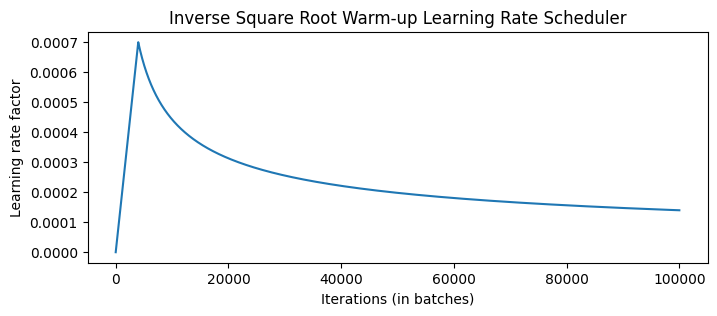

In [3]:
import torch.optim as optim
import torch.nn as nn
from utils import WarmupScheduler
import matplotlib.pyplot as plt

optimizer = optim.Adam(
    [nn.Parameter(torch.empty(4, 4))],
    betas=config.betas,
    eps=config.adam_eps,
)

scheduler = WarmupScheduler(optimizer, config.d_model, config.warmup_step)

lrs = []
for _ in range(100000):
    optimizer.step()
    lrs.append(scheduler.get_last_lr())
    scheduler.step()
plt.figure(figsize=(8, 3))
plt.plot(lrs)
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Inverse Square Root Warm-up Learning Rate Scheduler")
plt.show()

### 3.2 Label Smoothing
Label smoothing is a regularization technique that smooths the target labels when computing the loss, preventing the model from becoming overly confident in predicting single classes. Specifically, it transforms hard labels (one-hot vectors) into soft labels, introducing some uncertainty during training. This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.

We can do this directly with `torch.nn.CrossEntopyLoss` , but I have also prepared a clear and concise implementation in [utils.py](./utils.py).

In [4]:
from utils import LabelSmoothingLoss

criterion = LabelSmoothingLoss(
    ignore_index=tgt_tokenizer.token_to_id(PAD_TOKEN), label_smoothing=config.eps_ls
)
standard = torch.nn.CrossEntropyLoss(
    ignore_index=tgt_tokenizer.token_to_id(PAD_TOKEN), label_smoothing=config.eps_ls
)
vocab_size = tgt_tokenizer.get_vocab_size()
batch_size = 300
pred = torch.randn([batch_size, vocab_size])
gt = torch.randint(0, vocab_size, [batch_size])

criterion(pred, gt), standard(pred, gt)

(tensor(10.7579), tensor(10.7579))

In [5]:
def split_batch(batch):
    src, tgt = batch
    tgt, gt = tgt[:, :-1], tgt[:, 1:]
    return src.to(device), tgt.to(device), gt.to(device)


def train(epoch, model, criterion, optimizer, scheduler):
    model.train()
    total_loss = 0
    step = 0
    optimizer.zero_grad()

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        # tgt: the input of decoder
        # gt (ground truth): the training target
        src, tgt, gt = split_batch(batch)

        # [batch_size, seq_len, tgt_vocab_size]

        outputs = model(src, tgt)

        # [batch_size * seq_len, tgt_vocab_size]
        outputs = outputs.contiguous().view(-1, tgt_tokenizer.get_vocab_size())
        loss = criterion(outputs, gt.contiguous().view(-1))
        loss.backward()

        if (step + 1) % config.update_freq == 0 or (step + 1) == len(train_loader):
            nn.utils.clip_grad_norm_(model.parameters(), config.clip)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        step += 1
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    return avg_loss

In [6]:
import sacrebleu
from utils import greedy_search

sos_idx = tgt_tokenizer.token_to_id(SOS_TOKEN)
eos_idx = tgt_tokenizer.token_to_id(EOS_TOKEN)
pad_idx = tgt_tokenizer.token_to_id(PAD_TOKEN)


def evaluate(model, criterion):
    model.eval()
    total_loss = 0
    all_references = []
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(valid_loader, desc="Evaluating"):
            src, tgt, gt = split_batch(batch)

            enc_output = model.encode(src)
            src_mask = model.make_src_mask(src)
            dec_output = model.decode(tgt, enc_output, src_mask)

            loss = criterion(
                dec_output.contiguous().view(-1, tgt_tokenizer.get_vocab_size()),
                gt.contiguous().view(-1),
            )
            total_loss += loss.item()

            pred_tokens = greedy_search(
                model, enc_output, src_mask, config.max_len, sos_idx, eos_idx, pad_idx
            )
            pred_sentence = tgt_tokenizer.decode_batch(pred_tokens.cpu().numpy())
            target_sentence = tgt_tokenizer.decode_batch(gt.cpu().numpy())
            all_predictions.append("".join(pred_sentence))
            all_references.append(["".join(target_sentence)])

    avg_loss = total_loss / len(valid_loader)
    if len(all_predictions) > 0:
        bleu_score = sacrebleu.corpus_bleu(all_predictions, all_references)
        avg_bleu = bleu_score.score
    else:
        avg_bleu = 0
    return avg_loss, avg_bleu

In [ ]:
def training_loop(restore_epoch=0):
    optimizer = torch.optim.Adam(
        model.parameters(), betas=config.betas, eps=config.adam_eps
    )
    scheduler = WarmupScheduler(optimizer, config.d_model, config.warmup_step)
    criterion = LabelSmoothingLoss(
        ignore_index=tgt_tokenizer.token_to_id(PAD_TOKEN), label_smoothing=config.eps_ls
    )

    restore_ckpt_path = os.path.join(
        config.checkpoint_dir, f"en_de_{restore_epoch}.pth"
    )
    if restore_epoch != -1 and os.path.exists(restore_ckpt_path):
        ckpt = torch.load(restore_ckpt_path)
        assert ckpt["epoch"] == restore_epoch
        model.load_state_dict(ckpt["model"])
        optimizer.load_state_dict(ckpt["optimizer"])
        scheduler.load_state_dict(ckpt["scheduler"])
    else:
        restore_epoch = 0

    for epoch in range(restore_epoch - 1, config.epochs):
        avg_train_loss = train(epoch, model, criterion, optimizer, scheduler)
        avg_valid_loss, avg_bleu = evaluate(model, criterion)
        print(
            f"Epoch {epoch + 1}/{config.epochs}, Training Loss: {avg_train_loss: .4f}, Validation Loss: {avg_valid_loss:.4f}, BLEU Score: {avg_bleu:.2f}"
        )

        checkpoint_path = os.path.join(config.checkpoint_dir, f"en_de_{epoch + 1}.pth")
        torch.save(
            {
                "epoch": epoch + 1,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
            },
            checkpoint_path,
        )


training_loop()